In [1]:
import ase
import numpy as np

import abtem

# Customizing *ab*TEM

In this tutorial, we describe how to extend *ab*TEM and introduce a few general concepts on how the library works. This tutorial requires familarity with NumPy and in some parts a basic understanding of Dask.

:::{admonition} {material-regular}`engineering;1.5rem;sd-mr-1` Currently Under Construction
:class: no-icon
This section uses a new relatively untested feature.
:::

## The `ArrayObject`

In *ab*TEM we describe the $xy$-part of a wave function on a 2D grid using a 2D NumPy (or CuPy) array, an ensemble of such wave functions may also be described as a single array with an additional dimensions for each ensemble dimension, for example multiple different positions. We encapsulate that array together with metadata such as the energy and real-space extent and call it a `Waves` object. 

The `Waves` are an example of an `ArrayObject` which is the base class for any object in *ab*TEM represented mainly by a single NumPy (or CuPy) array and some metadata for example the energy and sampling of the wave function, another example is the `PotentialArray`. All `ArrayObject`s may also be be lazy utilizing a Dask array.

Objects such as the `Probe` and `Potential` are not `ArrayObject`'s, they act as an interface to create `Waves` and `PotentialArray`.

In [2]:
atoms = ase.build.mx2("WS2", vacuum=2)
atoms = abtem.orthogonalize_cell(atoms) * (7, 4, 1)

potential = abtem.Potential(atoms, sampling=0.05)

probe = abtem.Probe(energy=120e3, semiangle_cutoff=30)

probe.grid.match(potential)

waves = probe.build()

However, we can run the `.build` method to create `Waves`.

In [3]:
waves = probe.build()

You can create any custom wave function by creating a `Waves` object from a NumPy array. For example, we can take the array created by the `Probe` and apply a phase shift.

In [4]:
array = waves.array.compute()  # compute makes the Dask array into a NumPy array

new_array = array * np.exp(-1.0j * np.pi)

Any 2D Numpy array can be used to create a custom `Waves` object. To fully define a `Waves` object you also need to at least provide the energy and sampling.

In [5]:
custom_waves = abtem.Waves(
    array=new_array, energy=waves.energy, sampling=waves.sampling
)

To utilize Dask, we can use the `.lazy` method.

In [6]:
custom_waves = custom_waves.lazy()

custom_waves.array

dask.array<array, shape=(446, 441), dtype=complex64, chunksize=(446, 441), chunktype=numpy.ndarray>

In [7]:
stack = abtem.stack((waves, custom_waves), ("Probe", "Phase shifted probe"))

stack = stack.compute().to_images(convert_complex=False)

[########################################] | 100% Completed | 102.92 ms


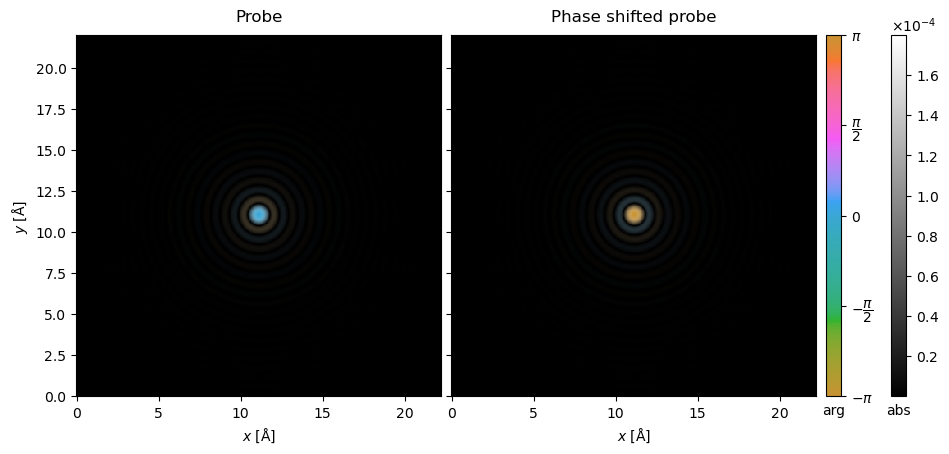

In [8]:
stack.show(
    explode=True, cbar=True, common_color_scale=True, figsize=(10, 10)
);

## Lazy function application

Next we will apply a somewhat more complicated function to the wave function array, a patterned phase plate as for example used in MIDI-STEM. The function below takes a `Waves` object and a set of angles for where the phase should be flipped by $\pi / 2$. The function uses mostly standard NumPy apart from some utility functions from *ab*TEM. 

We get the spatial frequencies and wavelength from the `Waves` object.

We use the `get_array_module` function to make our code agnostic to the array module. This function will return either the NumPy or the [CuPy](https://cupy.dev/) module, depending on the array type, thus enabling the relevant code to work on GPU's. 

We import `fft2_convolve` from *ab*TEM, this function calculates the FFT convolution using the library provided in the config FFTW, MKL or NumPy on CPU and cuFTT on GPU.

In [9]:
from abtem.core.backend import get_array_module
from abtem.core.fft import fft2_convolve


def phase_flip(
    waves: abtem.Waves,
    max_angle: float,
    num_flips: int,
    power: float,
    phase_shift: float = np.pi / 2,
) -> np.array:
    """
    Applies a radial phase flipping in reciprocal space to the input wave function array.

    Parameters
    ----------
    waves : Waves
        The abTEM electron wavefunction object.
    max_angle : float
        The maximum angle used to normalize the radial frequency at which phase flipping occurs [mrad].
    num_flips : int
        The number of flips in the phase applied within max_angle.
    power : float
        The exponent used in the power law scaling of frequency of phase flipping with radial spatial frequency.
    phase_shift : float, optional
        The phase shift value in radians applied to the flipped regions. Defaults to pi / 2.

    Returns
    -------
    np.ndarray
        An array representing the convolved wavefunction after the phase flip has been applied.
    """

    # Get spatial frequencies for the wave grid.
    kx, ky = waves.grid.spatial_frequencies()

    # Calculate the square of radial frequencies.
    k = np.sqrt(kx[:, None] ** 2 + ky[None] ** 2)

    # Convert max_angle to spatial frequencies, adjusted
    max_k = max_angle / waves.wavelength / 1e3

    # Apply power scaling to the radial frequencies and normalize.
    k_normed = (k / max_k) ** power

    # Generate a phase flip map using a sinusoidal function of the normalized radial frequencies,
    # where the sign of the sine function determines the flip condition.
    phase_flip_map = np.sin(k_normed * np.pi * (num_flips + 1)) < 0

    # We make our code device agnostic.
    xp = get_array_module(waves.array)
    phase_flip_map = xp.asarray(phase_flip_map)

    # Create a phase shift array for flipping by pi/2 radians.
    phase_shift = xp.exp(1.0j * phase_shift * phase_flip_map)

    # Convolve wave array with phase shift in Fourier space.
    array = fft2_convolve(waves.array, phase_shift)

    return array

We build a `Waves` object and apply the `phase_flip` function.

In [10]:
# We make sure to build the probe at (0., 0.) instead of the default center
waves = probe.build((0.0, 0.0))

waves.array = phase_flip(waves, max_angle=30.0, num_flips=5, power=2.0)

diffraction = waves.diffraction_patterns(return_complex=True).crop(80).compute()

[########################################] | 100% Completed | 203.23 ms


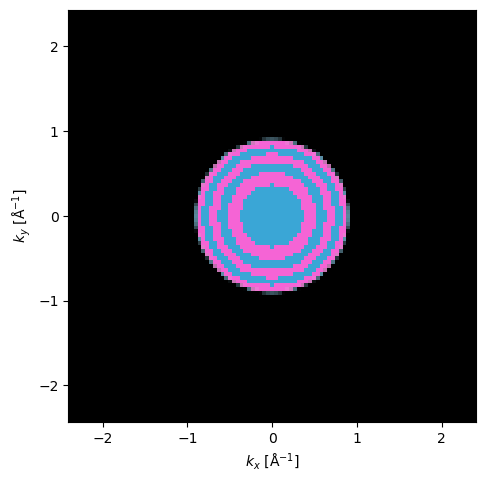

In [11]:
diffraction.show(cmap="hsluv");

The `phase_flip` function is applied lazily to the waves.

In [12]:
waves.is_lazy

True

There is a subtle issue here. The `phase_flip_map` array is calculated at the point of call, this is fine in this case, but goes against the idea of lazy evaluation. In addition the `phase_flip_map` array has to be placed into the Dask task graph, which can result in expensive serialization for distributed calculations.

The issue is quite simply overcome by using the `apply_func` method, which will apply the `phase_flip` function lazily when the `Waves` are lazy. In addition, `waves.array` inside the function is non-lazy at the point of compute and only the `angles` array is embedded in the task graph.

In [13]:
waves = probe.build((0.0, 0.0))

waves = waves.apply_func(phase_flip, max_angle=30.0, num_flips=5, power=2.0)

The `scan` method can be used as usual. 

```{note}
The scan objects shifts the `Waves` based on $(x,y)=(0,0)$. So, make sure the probe wave function is placed at (0, 0) before applying a scan. It also bears noting that resolving properties such as the scan Nyquist sampling based on a `Waves` object may fail.
```

In [14]:
scan = abtem.GridScan(
    start=(0, 0),
    end=(1 / 7, 1 / 4),
    sampling=0.4,
    fractional=True,
    potential=atoms,
)

waves = probe.build(scan=(0.0, 0.0)).apply_func(
    phase_flip, max_angle=30, num_flips=5, power=2
)

scanned_waves = waves.scan(scan=scan, potential=potential)

diffraction_patterns = scanned_waves.diffraction_patterns(return_complex=True)

diffraction_patterns.compute()

[########################################] | 100% Completed | 7.38 sms


We show the result as an exploded plot.

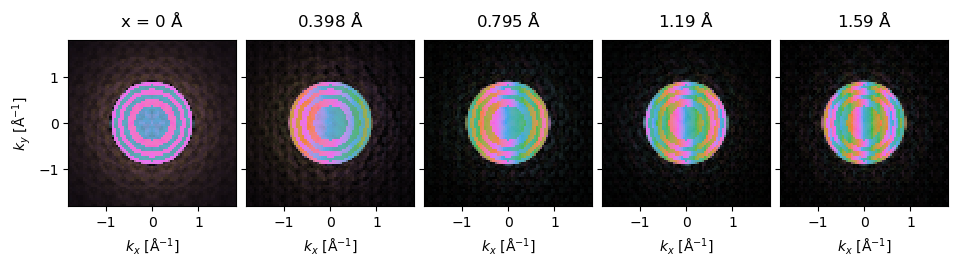

In [15]:
diffraction_patterns[:5, 0].crop(60).show(explode=True, figsize=(10, 6));

## Object-oriented implementation (`WavesTranform`)

A more formal extension to *ab*TEM may be accomplished by subclassing the `WavesTransform` or its parent class `ArrayObjectTransform`. By extending *ab*TEM this way, the implementation follows the object-oriented design of the code. For simulations with a large number of tasks this implementation may also allow *ab*TEM to better optimize the Dask task graph by merging tasks.

In this section, we show how to implement the example from the preceding section using a `WavesTransform`. We will create a new `PhaseRamp` object that takes the argument `gradient`, to do this we need three things:
* Implement the private `_calculate_new_array` method. This method takes a `Waves` object and returns a NumPy array of the same shape (unless otherwise specified, see further on)
* All input arguments should be exposed as public properties
* Add docstrings using the [NumPy docstring format](https://numpydoc.readthedocs.io/en/latest/format.html)

In [16]:
from typing import Sequence


class PatternedPhasePlate(abtem.transform.WavesTransform):
    """
    A patterned phase plate modifying the phase of an electron wavefunction at specific angles.

    Parameters
    ----------
    angles: sequence of float
        A sequence of angles at which the phase plate will flip the phase of the electron wavefunction [mrad].
    """

    def __init__(self, max_angle, num_flips, power):
        self.max_angle = max_angle
        self.num_flips = num_flips
        self.power = power
        super().__init__()

    def _calculate_new_array(self, waves: abtem.Waves) -> np.ndarray:
        return phase_flip(waves, self.max_angle, self.num_flips, self.power)

We can apply our `PatternedPhasePlate` object using the `apply_transform` method, which in addition to 

In [17]:
phase_plate = PatternedPhasePlate(30, 5, 2)

waves = probe.build((0.0, 0.0)).apply_transform(phase_plate)

diffraction = waves.diffraction_patterns(return_complex=True).crop(60).compute()

[########################################] | 100% Completed | 106.94 ms


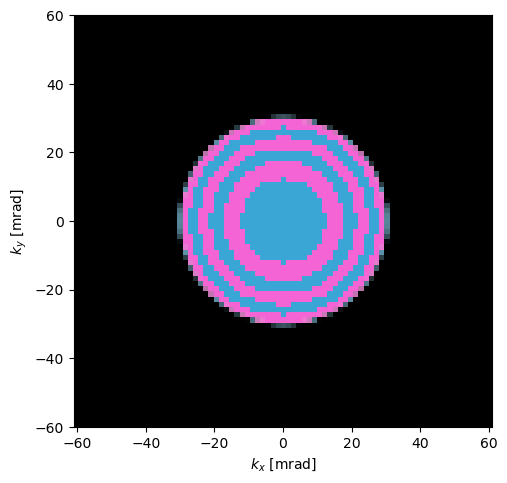

In [18]:
diffraction.show(units="mrad");

## Using existing metadata and broadcasting across ensemble axes

In the above, we supplied the semiangle cutoff explicitely, we can also get this from the metadata if the `Waves` are created from a `Probe`. If there 

Another way to do this is using the the `Phase`


In [19]:
waves.get_from_metadata(
    "semiangle_cutoff",
    broadcastable=True,
)

30

In [20]:
class PatternedPhasePlate(abtem.transform.WavesTransform):

    def __init__(
        self,
        num_flips: int,
        power: float = 2.0,
    ):
        self.num_flips = num_flips
        self.power = power

        super().__init__()

    def _calculate_new_array(self, waves: abtem.Waves) -> np.ndarray:
        semiangle_cutoff = waves.get_from_metadata(
            "semiangle_cutoff",
            broadcastable=True,
        )
        return phase_flip(waves, semiangle_cutoff, self.num_flips, self.power)

In [21]:
waves.array

dask.array<apply_transform, shape=(446, 441), dtype=complex64, chunksize=(446, 441), chunktype=numpy.ndarray>

In [22]:
patterned_phase_plate = PatternedPhasePlate(5, np.pi / 2)

patterned_waves = waves.apply_transform(patterned_phase_plate)

diffraction = patterned_waves.diffraction_patterns(return_complex=True).crop(60).compute()

[########################################] | 100% Completed | 102.45 ms


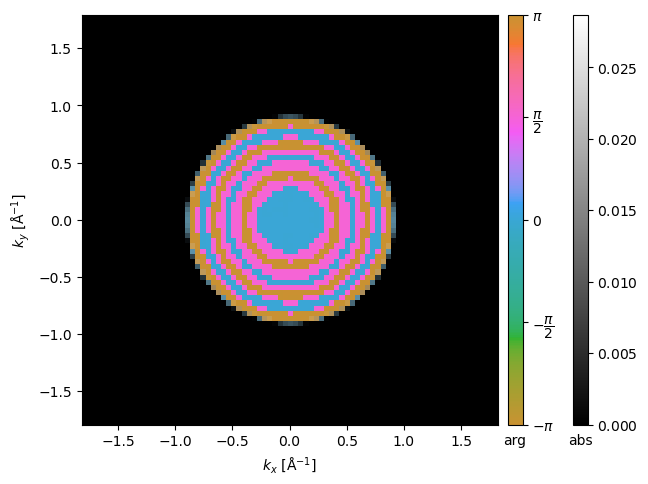

In [23]:
diffraction.show(cbar=True, vmin=0.);

## Distributions of parameters (advanced)

:::{admonition} {material-regular}`engineering;1.5rem;sd-mr-1` Currently Under Construction
:class: no-icon
This section uses a new relatively untested feature.
:::

*ab*TEM provides an easy way to simulate multiple values of a specific parameter. This is used when, for example, simulating partial coherence or of course to simulate multiple probe positions.

In [24]:
ctf = abtem.CTF(defocus=np.linspace(0, 100, 100))

waves = probe.build((0.0, 0.0)).apply_transform(ctf, max_batch=25)

waves.array

dask.array<apply_transform, shape=(100, 446, 441), dtype=complex64, chunksize=(25, 446, 441), chunktype=numpy.ndarray>

To enable this in an extension we need to do a few more things: 

* We need to use the private `_validate_distribution` method on all parameters that should allow a distribution. This ensure the correctness of the input and converts it to a proper *ab*TEM distribution if it is not already one. 
* The `super` class (i.e. `WavesTransform`) need to know that a property is a distribution, this is accomplished by providing the names of the "distribution" parameters.
* Implement the `ensemble_axes_metadata` property. This should return a list of `AxisMetadata` objects, one for each added array dimension.